<a href="https://colab.research.google.com/github/Russellkusuma/TrashRecogntion/blob/main/CSCI467_FinalProject_TrashRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [228]:
# Lets follow a guide? Though this uses pytorch! https://www.kaggle.com/code/aadhavvignesh/pytorch-garbage-classification-95-accuracy
# MOBILENET IDEA, uses tensorflow! https://www.kaggle.com/code/ranaazeem/garbage-classification-using-mobilenetv2-93-acc
# Lab report inspire https://cs229.stanford.edu/proj2016/report/ThungYang-ClassificationOfTrashForRecyclabilityStatus-report.pdf
import torchvision
# List available models
# all_models = torchvision.list_models()
# classification_models = torchvision.list_models(module=torchvision.models)


In [229]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F


# Data Collection and PreProcessing

Load dataset from google drive

In [230]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Russell Directory
data_dir ='/content/drive/MyDrive/Colab Notebooks/Datasets/CCHANGCS_Garbage ClassificationDataset.zip (Unzipped Files)/Garbage classification/Garbage classification'


# data_dir = '/content/drive/MyDrive/CS467/Datasets/CCHANGCS_Garbage ClassificationDataset.zip (Unzipped Files)/Garbage classification/Garbage classification'
# data_dir = '/content/drive/MyDrive/Datasets/CCHANGCS_Garbage ClassificationDataset.zip (Unzipped Files)/Garbage classification/Garbage classification'
classes = os.listdir(data_dir)
print(classes)

Mounted at /content/drive
['glass', 'cardboard', 'metal', 'paper', 'plastic', 'trash']


In [231]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Preprocess the images to ideal sizes for the models

In [232]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

# Data augmentation and normalization for training
#(224),(224)
target_size = (224,224) # 256,256 for Resnet, 224,224 for mobilenet and alexnet

transformations = transforms.Compose([
    transforms.Resize(target_size),
    #transforms.Resize((256,341)), 
    #transforms.RandomCrop(size = target_size),
    transforms.ToTensor(),
    #transforms.Normalize([0.6610, 0.6283, 0.5894], [0.2085, 0.2085, 0.2302]) # ImageNet prior
  ])

dataset = ImageFolder(data_dir, transform = transformations)
print(dataset.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Assign each image with their assigned class for comparison purposes

In [233]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

dataset.classes[0]

'cardboard'

Print sample of training data with assigned label

Label: cardboard (Class No: 0)


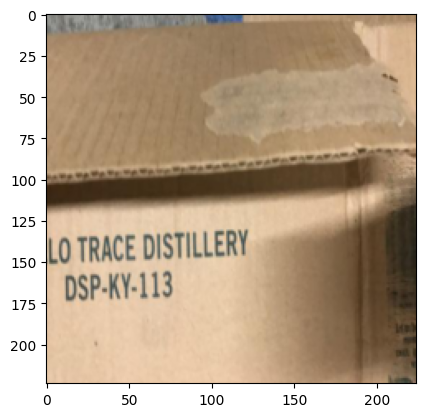

In [234]:
img, label = dataset[12]
show_sample(img, label)

Randomly allocate images to Training,Dev,Test sets

In [235]:
random_seed = 42
torch.manual_seed(random_seed)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /content/drive/MyDrive/Colab Notebooks/Datasets/CCHANGCS_Garbage ClassificationDataset.zip (Unzipped Files)/Garbage classification/Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [236]:
print(len(dataset))
total = len(dataset)
print((total*0.7), (total*0.1), (total*0.2))
#train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
train_ds, val_ds, test_ds = random_split(dataset, [1769 , 253 , 505])
len(train_ds), len(val_ds), len(test_ds)

2527
1768.8999999999999 252.70000000000002 505.40000000000003


(1769, 253, 505)

In [237]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [238]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [239]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

In [240]:
# show_batch(train_dl)

# Training

Training Algorithm

In [241]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

CNN Models setup as classes

In [242]:
#@title MODEL SELECTION
# Alexnet?
import torchvision.models
from torchvision.models import list_models, get_model
# List available models
print(list_models())
print(list_models(module=torchvision.models))



# Initialize models, temporary use premade models

class AlexNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = torchvision.models.alexnet(pretrained=True)
        # for param in self.network.features.parameters():
        #    param.requires_grad = False
        self.network.classifier = nn.Sequential(
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=9216, out_features=4096, bias=True),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(4096, 1024, True),
        nn.ReLU(inplace=True),
        nn.Linear(1024, len(dataset.classes), True),
        )

      #       (classifier): Sequential(
      # (0): Dropout(p=0.5, inplace=False)
      # (1): Linear(in_features=9216, out_features=4096, bias=True)
      # (2): ReLU(inplace=True)
      # (3): Dropout(p=0.5, inplace=False)
      # (4): Linear(in_features=4096, out_features=4096, bias=True)
      # (5): ReLU(inplace=True)
      # (6): Linear(in_features=4096, out_features=1000, bias=True)
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

# class MobileNet(ImageClassificationBase):
#     def __init__(self):
#         super().__init__()
#         self.network = torchvision.models.mobilenet_v2(pretrained=True)
#         for param in self.network.parameters():
#             param.requires_grad = False
#         num_ftrs = self.network.classifier[1].in_features
#         self.network.classifier[1] = nn.Linear(num_ftrs, len(dataset.classes))
#     def forward(self, xb):
#         return torch.sigmoid(self.network(xb))

# class AlexNet(ImageClassificationBase):
#     def __init__(self, num_classes = len(dataset.classes)):
#         super(AlexNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
#             nn.BatchNorm2d(96),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.fc = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(6400, 4096),
#             nn.ReLU())
#         self.fc1 = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU())
#         self.fc2= nn.Sequential(
#             nn.Linear(4096, num_classes))
        
#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
#         out = out.reshape(out.size(0), -1)
#         out = self.fc(out)
#         out = self.fc1(out)
#         out = self.fc2(out)
#         return out

# class MobileNet(ImageClassificationBase):
#     def __init__(self, num_classes = len(dataset.classes)):
#         super(MobileNet, self).__init__()

#         def conv_bn(inp, oup, stride):
#             return nn.Sequential(
#                 nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
#                 nn.BatchNorm2d(oup),
#                 nn.ReLU(inplace=True)
#             )

#         def conv_dw(inp, oup, stride):
#             return nn.Sequential(
#                 nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
#                 nn.BatchNorm2d(inp),
#                 nn.ReLU(inplace=True),
    
#                 nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
#                 nn.BatchNorm2d(oup),
#                 nn.ReLU(inplace=True),
#             )

#         self.model = nn.Sequential(
#             conv_bn(  3,  32, 2), 
#             conv_dw( 32,  64, 1),
#             conv_dw( 64, 128, 2),
#             conv_dw(128, 128, 1),
#             conv_dw(128, 256, 2),
#             conv_dw(256, 256, 1),
#             conv_dw(256, 512, 2),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 1024, 2),
#             conv_dw(1024, 1024, 1),
#             nn.AvgPool2d(7),
#         )
#         self.fc = nn.Linear(1024, num_classes)

#     def forward(self, x):
#         x = self.model(x)
#         x = x.view(-1, 1024)
#         x = self.fc(x)
#         return x

class ResNet50(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
        

class ResNet101(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet101(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

class ResNet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

class WideResNet101(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.wide_resnet101_2(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

class MobileNet_V3L(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = torchvision.models.mobilenet_v3_large(pretrained=True)
        # # Replace last layer
        self.network.classifier = nn.Sequential(
        nn.Linear(960, 1280, bias=True),
        nn.Hardswish(),
        nn.Dropout(0.2, True),
        nn.Linear(1280, len(dataset.classes), True)
        )
      #   (classifier): Sequential(
      # (0): Linear(in_features=960, out_features=1280, bias=True)
      # (1): Hardswish()
      # (2): Dropout(p=0.2, inplace=True)
      # (3): Linear(in_features=1280, out_features=1000, bias=True)
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

class MobileNet_V3S(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = torchvision.models.mobilenet_v3_small(pretrained=True)
        # # Replace last layer
        self.network.classifier = nn.Sequential(
        nn.Linear(576, 1024, bias=True),
        nn.Hardswish(),
        nn.Dropout(0.2, True),
        nn.Linear(1024, len(dataset.classes), True)
        )
    # (classifier): Sequential(
    #   (0): Linear(in_features=576, out_features=1024, bias=True)
    #   (1): Hardswish()
    #   (2): Dropout(p=0.2, inplace=True)
    #   (3): Linear(in_features=1024, out_features=1000, bias=True)
    # )
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

class SqueezeNet_V1p1(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = torchvision.models.squeezenet1_1(pretrained=False)
        # # Replace last layer
        self.network.classifier = nn.Sequential(
        nn.Dropout(p=0.5, inplace=False),
        nn.Conv2d(512, len(dataset.classes), kernel_size=(1, 1)),
        nn.ReLU(inplace=True),
        nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )

      #       (classifier): Sequential(
      # (0): Dropout(p=0.5, inplace=False)
      # (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
      # (2): ReLU(inplace=True)
      # (3): AdaptiveAvgPool2d(output_size=(1, 1))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

class EfficientNetV2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.efficientnet_v2_l(pretrained=True)
        # # Replace last layer
        self.network.classifier = nn.Sequential(
        nn.Dropout(0.4, True),
        nn.Linear(1280, len(dataset.classes), True)
        )
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

#model = SqueezeNet_V1p1()
model = AlexNet()

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'deeplabv3_mobilenet_v3_large', 'deeplabv3_resnet101', 'deeplabv3_resnet50', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'fasterrcnn_mobilenet_v3_large_320_fpn', 'fasterrcnn_mobilenet_v3_large_fpn', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet50_fpn_v2', 'fcn_resnet101', 'fcn_resnet50', 'fcos_resnet50_fpn', 'googlenet', 'inception_v3', 'keypointrcnn_resnet50_fpn', 'lraspp_mobilenet_v3_large', 'maskrcnn_resnet50_fpn', 'maskrcnn_resnet50_fpn_v2', 'maxvit_t', 'mc3_18', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mvit_v1_b', 'mvit_v2_s', 'quantized_googlenet', 'quantized_inception_v3', 'quantized_mobilenet_v2

Easy to setup, just choose a model from the premade selections shown here:https://pytorch.org/vision/stable/models.html

Choosing to use the GPU from google colab 

In [243]:
# for name, param in model.named_parameters():
#     print(f'{name:30}{param.requires_grad}')

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
# device = torch.device('cpu')
print(device)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device)

cuda


AlexNet(
  (network): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (

Training algorithm for model

In [244]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5, verbose=True)
    val_loss = 0
    for epoch in range(epochs):
        # Training Phase
        train_losses = []
        # scheduler.step(val_loss)
        model.train()
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        val_loss = result['train_loss']
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Begin Training

In [245]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.5706, val_loss: 1.4165, val_acc: 0.5729
Epoch 2: train_loss: 1.3619, val_loss: 1.3766, val_acc: 0.6399
Epoch 3: train_loss: 1.2964, val_loss: 1.3285, val_acc: 0.6993
Epoch 4: train_loss: 1.2427, val_loss: 1.2818, val_acc: 0.7266
Epoch 5: train_loss: 1.2076, val_loss: 1.3272, val_acc: 0.6436
Epoch 6: train_loss: 1.1946, val_loss: 1.2768, val_acc: 0.6911
Epoch 7: train_loss: 1.1746, val_loss: 1.2421, val_acc: 0.7702
Epoch 8: train_loss: 1.1594, val_loss: 1.2357, val_acc: 0.7985
Epoch 9: train_loss: 1.1450, val_loss: 1.2550, val_acc: 0.7702
Epoch 10: train_loss: 1.1341, val_loss: 1.2615, val_acc: 0.7706
Epoch 11: train_loss: 1.1263, val_loss: 1.2463, val_acc: 0.7707
Epoch 12: train_loss: 1.1151, val_loss: 1.2338, val_acc: 0.8100
Epoch 13: train_loss: 1.1067, val_loss: 1.2347, val_acc: 0.8024
Epoch 14: train_loss: 1.0900, val_loss: 1.2158, val_acc: 0.8059
Epoch 15: train_loss: 1.0750, val_loss: 1.1962, val_acc: 0.8416
Epoch 16: train_loss: 1.0719, val_loss: 1.2065, v

# Save Model and display stats

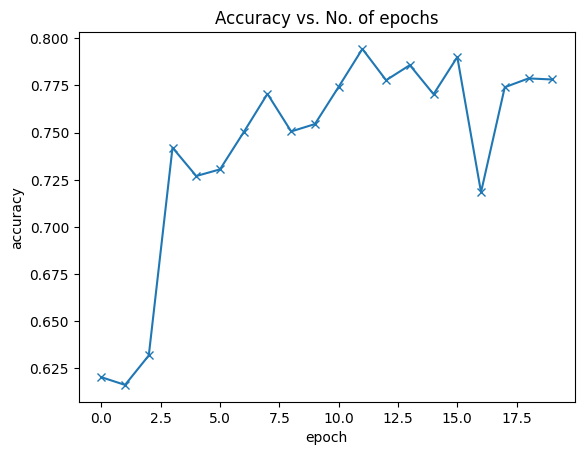

In [226]:

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

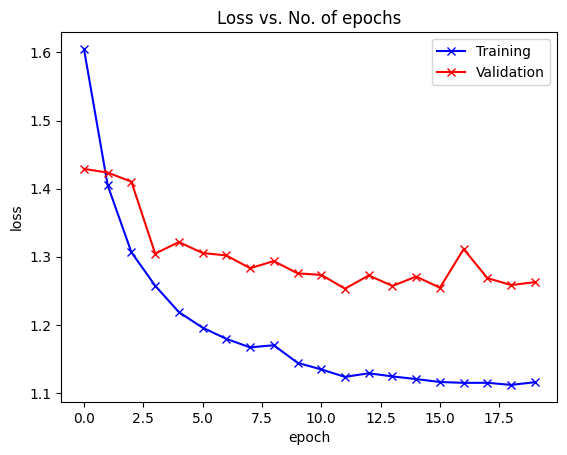

In [227]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [207]:
from google.colab import drive
drive.mount('/content/drive')

model_save_name = 'AlexNetNew_May9.pt'
# model_save_name_dict = 'ResNet101_May8_dict.pt'
path = f"/content/drive/MyDrive/Colab Notebooks/TrashModels/{model_save_name}" 
# dict_path = f"/content/drive/MyDrive/Colab Notebooks/TrashModels/{model_save_name_dict}" 

# Save
# torch.save(model.state_dict(), dict_path)
torch.save(model, path)

# from google.colab import files
# torch.save(model.state_dict(), 'mar22_Mobile.pth')

# # download checkpoint file
# files.download('mar22_Mobile.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.save(model.state_dict(), dict_path)# from google.colab import files
# uploaded = files.upload()

# **ANALYZE AND JUDGE MODELS**

In [ ]:
model = ResNet50()
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/TrashModels/ResNetPT_April17_compost.pt'))
model = torch.load('/content/drive/MyDrive/Colab Notebooks/TrashModels/ResNetPT_April17_compost.pt')

model.eval()
print(device)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:


img, label = test_ds[80]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

y_pred = []
y_true = []

# iterate over test data
for img, label in test_ds:
        # img, label = test_ds[x]
        y_pred.append(predict_image(img, model)) # Save Prediction
        y_true.append(dataset.classes[label]) # Save Truth

print(y_pred)

print(y_true)
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

# IGNORE: EE459 STUFF

In [ ]:
# # Saving model
# model_save_name = 'ResNetPT_April17_TS_CPU.pt'
# path = F"/content/drive/MyDrive/Colab Notebooks/TrashModels/{model_save_name}" 
# model_scripted = torch.jit.script(model) # Export to TorchScript
# model_scripted.save(path) # Save

In [ ]:
# model_save_name = 'ResNetPT_April17_TS_CPU.pt'
# path = F"/content/drive/MyDrive/Colab Notebooks/TrashModels/{model_save_name}" 
# model = torch.jit.load(path)
# model.eval()

# img, label = test_ds[51]
# plt.imshow(img.permute(1, 2, 0))
# print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
# print(dataset.classes)